# Spam Email classification

Dataset: http://archive.ics.uci.edu/ml/datasets/Spambase

### GOAL

Determine whether a given email is spam or not.

### RESULT

1st: Explore data

2nd: Find the best model based on the highest accuracy (LighGBM)

3rd: Find the best cost-sensitive prediction model (LightGBM)

### Class Distribution:

Spam	  1813  (39.4%),
Non-Spam  2788  (60.6%)

### Variable description

SPAM E-MAIL ATTRIBUTES (in spambase.names)

The last column of 'spambase.data' denotes whether the e-mail was considered spam (1) or not (0), i.e. unsolicited commercial e-mail. Most of the attributes indicate whether a particular word or character was frequently occuring in the e-mail. The run-length attributes (55-57) measure the length of sequences of consecutive capital letters. For the statistical measures of each attribute, see the end of this file. Here are the definitions of the attributes:

48 continuous real [0,100] attributes of type word_freq_WORD
= percentage of words in the e-mail that match WORD, i.e. 100 * (number of times the WORD appears in the e-mail) / total number of words in e-mail. A "word" in this case is any string of alphanumeric characters bounded by non-alphanumeric characters or end-of-string.

6 continuous real [0,100] attributes of type char_freq_CHAR]
= percentage of characters in the e-mail that match CHAR, i.e. 100 * (number of CHAR occurences) / total characters in e-mail

1 continuous real [1,...] attribute of type capital_run_length_average
= average length of uninterrupted sequences of capital letters

1 continuous integer [1,...] attribute of type capital_run_length_longest
= length of longest uninterrupted sequence of capital letters

1 continuous integer [1,...] attribute of type capital_run_length_total
= sum of length of uninterrupted sequences of capital letters
= total number of capital letters in the e-mail

1 nominal {0,1} class attribute of type spam
= denotes whether the e-mail was considered spam (1) or not (0), i.e. unsolicited commercial e-mail.

## Data processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
%matplotlib inline

from sklearn.metrics import fbeta_score, make_scorer, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.datasets import mnist 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt

import warnings
warnings.filterwarnings("ignore")

In [5]:
col=['word_freq_make','word_freq_address','word_freq_all','word_freq_3d','word_freq_our',
'word_freq_over','word_freq_remove','word_freq_internet','word_freq_order',
'word_freq_mail','word_freq_receive','word_freq_will','word_freq_people','word_freq_report',
'word_freq_addresses','word_freq_free','word_freq_business','word_freq_email','word_freq_you',
'word_freq_credit','word_freq_your','word_freq_font','word_freq_000','word_freq_money','word_freq_hp',
'word_freq_hpl','word_freq_george','word_freq_650','word_freq_lab','word_freq_labs',
'word_freq_telnet''word_freq_857','word_freq_data','word_freq_415','word_freq_85','word_freq_technology',
'word_freq_1999','word_freq_parts','word_freq_pm','word_freq_direct','word_freq_cs','word_freq_meeting',
'word_freq_original','word_freq_project','word_freq_re','word_freq_edu','word_freq_table',
'word_freq_conference','char_freq_;','char_freq_(','char_freq_[','char_freq_!',
'char_freq_$','char_freq_#','wf','capital_run_length_average','capital_run_length_longest',
'capital_run_length_total','prediction']

data = pd.read_csv('spambase.data', names=col, index_col=False)
data.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,wf,capital_run_length_average,capital_run_length_longest,capital_run_length_total,prediction
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [6]:
data['prediction'] = data['prediction'].astype('category')

In [7]:
n_samples, n_features = data.shape
print ('The dimensions of the data set are', n_samples, 'by', n_features)

The dimensions of the data set are 4601 by 58


## Exploratory Data Analysis

In [8]:
data.describe()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,wf,capital_run_length_average,capital_run_length_longest,capital_run_length_total
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.031869,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.285735,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,10.000000,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000


<AxesSubplot:>

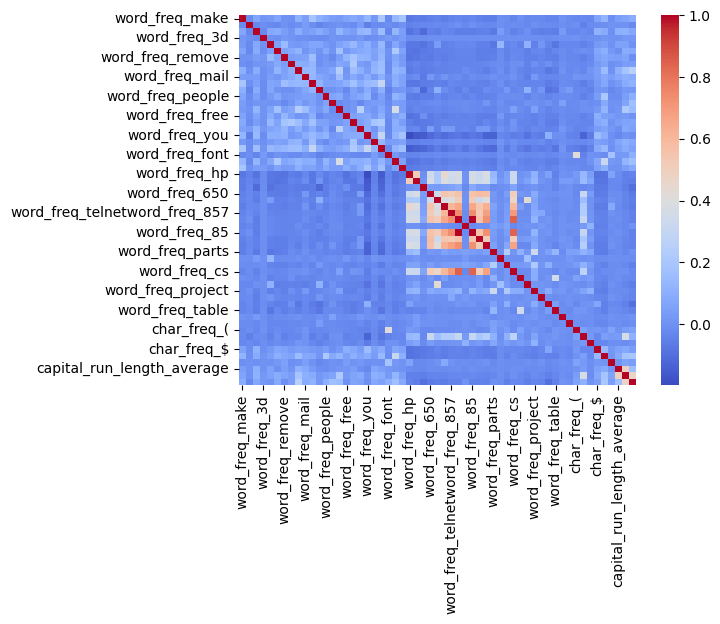

In [9]:
corr = data.corr()
sns.heatmap(corr, cmap = 'coolwarm')

In [7]:
X = data.drop('prediction',axis=1)
y = data[['prediction']]

In [8]:
# Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_normalized = scaler.fit_transform(X)
x_normalized = pd.DataFrame(x_normalized, columns=X.columns)

# Modeling(i) : best accuracy

I tried decision tree, logistic regression, KNN, SVM, LightGBM, Neutral Network methods. The following shows the best model based on accuracy and the best cost-sensitive model.

In [9]:
score = 'accuracy'

### Cross-validation for inner and outer loops

In [10]:
i = 42
inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

### Tuning Hyperparameter

In [11]:
# Decision Tree
tree = DecisionTreeClassifier()
depth = list(range(2,10))
msl = list(range(1,5))
dt_grid = {'max_depth': depth,'min_samples_leaf': msl}

# Logistic Regression
lr = LogisticRegression(solver='liblinear')
c_rng = [0.1, 1, 10, 100, 1000]
lr_grid = {'C': c_rng}

# KNN
knn =  KNeighborsClassifier()
k = list(range(2,5))
knn_grid = {'n_neighbors':k}

# SVM
svm = SVC()
kernels = ['rbf']
c = [1,10,100]
g = [0.1,0.5,1,5,10]
svm_grid = {'kernel':kernels,'C':c,'gamma':g} 

# LightGBM
lgb = LGBMClassifier()
md = [30,40,50,60,70]
leaves = [30,40,50,60,70]
rate = [0.05,0.1,0.3]
lgb_grid = {'max_depth':md,'num_leaves':leaves,'learning_rate':rate}

# Neutral Network
def create_model(activation, nb_hidden):
    model = Sequential()
    model.add(Dense(nb_hidden, activation=activation))
    model.add(Dense(nb_hidden, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

NN = KerasClassifier(build_fn=create_model, epochs=30, batch_size=256, verbose=0)
NN_grid = {'activation':['relu','sigmoid'],'nb_hidden':[10,20,30,40,50,60,70,80,90,100]}

### Non-nested parameter search and scoring

In [12]:
# Accuracy (score = 'accuracy')
dt_clf = GridSearchCV(estimator=tree, param_grid=dt_grid, scoring = score, cv=inner_cv)
lr_clf = GridSearchCV(estimator=lr, param_grid=lr_grid, scoring = score, cv=inner_cv)
knn_clf = GridSearchCV(estimator=knn, param_grid=knn_grid, scoring = score, cv=inner_cv)
svm_clf = GridSearchCV(estimator=svm, param_grid=svm_grid, scoring = score, cv=inner_cv)
lgb_clf = GridSearchCV(estimator=lgb, param_grid=lgb_grid, scoring = score, cv=inner_cv)
NN_clf = GridSearchCV(estimator=NN, param_grid=NN_grid, scoring = score, cv=inner_cv)

### Nested CV with parameter optimization

In [13]:
# accurate model
dt_score = cross_val_score(dt_clf, X=X, y=y, cv=outer_cv) # decision tree
lr_score = cross_val_score(lr_clf, X=x_normalized, y=y, cv=outer_cv) # logistic regression
knn_score = cross_val_score(knn_clf, X=x_normalized, y=y, cv=outer_cv) # knn
svm_score = cross_val_score(svm_clf, X=x_normalized, y=y, cv=outer_cv) # SVM
lgb_score = cross_val_score(lgb_clf, X=X.values, y=y, cv=outer_cv) # LightGBM
NN_score = cross_val_score(NN_clf, X=x_normalized, y=y, cv=outer_cv) # Neural Network

27/27 [==============================] - 0s 1ms/step


36/36 [==============================] - 0s 2ms/step


### (i) Compare accuarcy between 6 models

LighGBM performs the best with 95.2% accuracy.

In [14]:
score = {}
score['Decision Tree'] = dt_score.mean()
score['Logistic Regression'] = lr_score.mean()
score['KNN'] = knn_score.mean()
score['SVM'] = svm_score.mean()
score['LightGBM'] = lgb_score.mean()
score['Neural Network'] = NN_score.mean()
score

{'Decision Tree': 0.9224079250557171,
 'Logistic Regression': 0.9256680391342123,
 'KNN': 0.8948067842707664,
 'SVM': 0.935665017187323,
 'LightGBM': 0.9521824122691044,
 'Neural Network': 0.9360994220526574}

## (i) Best model: LightGBM

### Train-Test Split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Normalized

In [42]:
scaler=MinMaxScaler()
scaler=scaler.fit(X_train)
X_train[X_train.columns] = scaler.transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

### Fit the model

In [43]:
score = 'accuracy'

depth = [30,40,50,60,70]
leaves = [30,40,50,60,70]
rate = [0.05,0.1,0.3]
lgb_grid = {'max_depth':depth, 'num_leaves':leaves,'learning_rate':rate}
lgb = LGBMClassifier()
lgb_clf = GridSearchCV(estimator=lgb, param_grid=lgb_grid, scoring = score, cv=inner_cv)

In [44]:
lgb_clf.fit(X_train.values, y_train)
y_train_lgb = lgb_clf.predict(X_train.values)
y_pred_lgb = lgb_clf.predict(X_test.values)

### Evaluation

In [45]:
print('best params: ', lgb_clf.best_params_)
print('best score: ', lgb_clf.best_score_)
print('Training set score:', accuracy_score(y_train, y_train_lgb))
print('Testing set score:', accuracy_score(y_test, y_pred_lgb))
print(confusion_matrix(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb))

best params:  {'learning_rate': 0.1, 'max_depth': 30, 'num_leaves': 50}
best score:  0.9559782608695653
Training set score: 0.9991847826086957
Testing set score: 0.9609120521172638
[[520  11]
 [ 25 365]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       531
           1       0.97      0.94      0.95       390

    accuracy                           0.96       921
   macro avg       0.96      0.96      0.96       921
weighted avg       0.96      0.96      0.96       921



The best hyperparameter = {'learning_rate': 0.1, 'max_depth': 30, 'num_leaves': 50}

Accuracy = 99% on training set and 96% on testing set

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

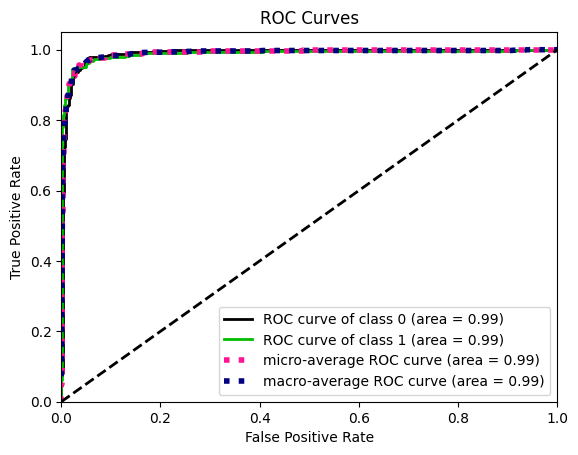

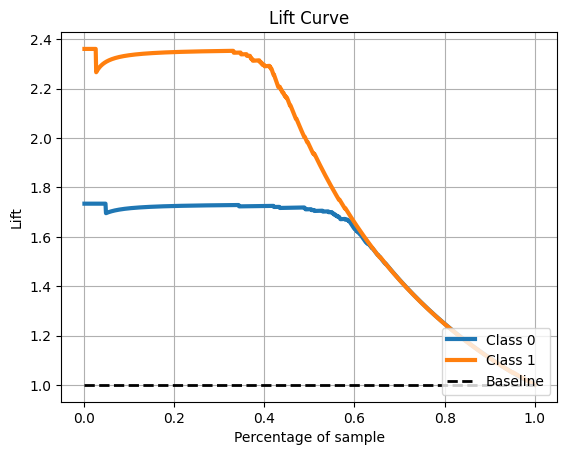

In [46]:
prob = lgb_clf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, prob)
skplt.metrics.plot_lift_curve(y_test, prob)

The ROC curve performs well (closed to top left).

The lift curve shows that when capturing 20% of the sample, the predictive model will get 1.7 times more 'not spam' data than random model (class=0), and 2.3 times more 'spam' than random one (class=1).

# Modeling(ii) : best cost-sensitive

Use 10:1 cost ratio for different misclassification errors. 
FPR (classify non-spam as spam):10, FNR(classify spam as non-spam):1

In [24]:
def cost(true, pred):
    cm = confusion_matrix(true, pred)
    cost = cm[0][1] * 10 + cm[1][0] * 1
    return cost

mis_cost = make_scorer(cost, greater_is_better= False)

### Cross-validation for inner and outer loops

In [10]:
i = 42
inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

### Tuning Hyperparameter

In [26]:
# Decision Tree
tree = DecisionTreeClassifier()
depth = list(range(2,10))
msl = list(range(1,5))
dt_grid = {'max_depth': depth,'min_samples_leaf': msl}

# Logistic Regression
lr = LogisticRegression(solver='liblinear')
c_rng = [0.1, 1, 10, 100, 1000]
lr_grid = {'C': c_rng}

# KNN
knn =  KNeighborsClassifier()
k = list(range(2,5))
knn_grid = {'n_neighbors':k}

# SVM
svm = SVC()
kernels = ['rbf']
c = [1,10,100]
g = [0.1,0.5,1,5,10]
svm_grid = {'kernel':kernels,'C':c,'gamma':g} 

# LightGBM
lgb = LGBMClassifier()
md = [30,40,50,60,70]
leaves = [30,40,50,60,70]
rate = [0.05,0.1,0.3]
lgb_grid = {'max_depth':md,'num_leaves':leaves,'learning_rate':rate}

# Neutral Network
def create_model(activation, nb_hidden):
    model = Sequential()
    model.add(Dense(nb_hidden, activation=activation))
    model.add(Dense(nb_hidden, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['MeanSquaredError'])
    return model

NN = KerasClassifier(build_fn=create_model, epochs=30, batch_size=256, verbose=0)
NN_grid = {'activation':['relu','sigmoid'],'nb_hidden':[10,20,30,40,50,60,70,80,90,100]}

### Non-nested parameter search and scoring

In [27]:
# cost (score = mis_cost)
dt_clf = GridSearchCV(estimator=tree, param_grid=dt_grid, scoring = mis_cost, cv=inner_cv)
lr_clf = GridSearchCV(estimator=lr, param_grid=lr_grid, scoring = mis_cost, cv=inner_cv)
knn_clf = GridSearchCV(estimator=knn, param_grid=knn_grid, scoring = mis_cost, cv=inner_cv)
svm_clf = GridSearchCV(estimator=svm, param_grid=svm_grid, scoring = mis_cost, cv=inner_cv)
lgb_clf = GridSearchCV(estimator=lgb, param_grid=lgb_grid, scoring = mis_cost, cv=inner_cv)
NN_clf = GridSearchCV(estimator=NN, param_grid=NN_grid, scoring = mis_cost, cv=inner_cv)

### Nested CV with parameter optimization

In [28]:
# cost-seneitive model
dt_cost = cross_val_score(dt_clf, X=X, y=y, cv=outer_cv) # decision tree
lr_cost = cross_val_score(lr_clf, X=x_normalized, y=y, cv=outer_cv) # logistic regression
knn_cost = cross_val_score(knn_clf, X=x_normalized, y=y, cv=outer_cv) # knn
svm_cost = cross_val_score(svm_clf, X=x_normalized, y=y, cv=outer_cv) # SVM
lgb_cost = cross_val_score(lgb_clf, X=X.values, y=y, cv=outer_cv) # LightGBM
NN_cost = cross_val_score(NN_clf, X=x_normalized, y=y, cv=outer_cv) # Neural Network

27/27 [==============================] - 0s 1ms/step


36/36 [==============================] - 0s 941us/step


### (ii) Compare cost between 6 models

LightGBM has the lowest cost (296.25).

In [29]:
cost = {}
cost['Decision Tree'] = -dt_cost.mean()
cost['Logistic Regression'] = -lr_cost.mean()
cost['KNN'] = -knn_cost.mean()
cost['SVM'] = -svm_cost.mean()
cost['LightGBM'] = -lgb_cost.mean()
cost['Neural Network'] = -NN_cost.mean()
cost

{'Decision Tree': 377.25,
 'Logistic Regression': 391.75,
 'KNN': 415.0,
 'SVM': 345.5,
 'LightGBM': 296.25,
 'Neural Network': 409.25}

## (ii) Best cost sensitive model:  LightGBM

### Train-Test Split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Normalized

In [48]:
scaler=MinMaxScaler()
scaler=scaler.fit(X_train)
X_train[X_train.columns] = scaler.transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

### Fit the model

In [49]:
score = mis_cost

lgb_grid = {'max_depth':[30,40,50,60,70],'num_leaves':[30,40,50,60,70],'learning_rate':[0.05,0.1,0.3]}
lgb = LGBMClassifier()
lgb_clf = GridSearchCV(estimator=lgb, param_grid=lgb_grid, scoring = score, cv=inner_cv)

In [50]:
lgb_clf.fit(X_train.values, y_train)
y_train_lgb = lgb_clf.predict(X_train.values)
y_pred_lgb = lgb_clf.predict(X_test.values)

### Evaluation

In [51]:
print('best params: ', lgb_clf.best_params_)
print('best score: ', -lgb_clf.best_score_)
print('Training set score:', accuracy_score(y_train, y_train_lgb))
print('Testing set score:', accuracy_score(y_test, y_pred_lgb))
print(confusion_matrix(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb))

best params:  {'learning_rate': 0.3, 'max_depth': 30, 'num_leaves': 50}
best score:  205.5
Training set score: 0.9994565217391305
Testing set score: 0.9565689467969598
[[520  11]
 [ 29 361]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       531
           1       0.97      0.93      0.95       390

    accuracy                           0.96       921
   macro avg       0.96      0.95      0.96       921
weighted avg       0.96      0.96      0.96       921



The best hyperparameter = {'learning_rate': 0.3, 'max_depth': 30, 'num_leaves': 50}

Accuracy is 99% on training set and 96% on testing set

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

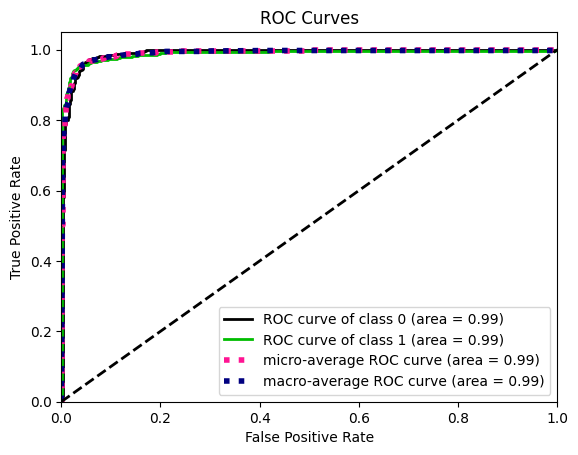

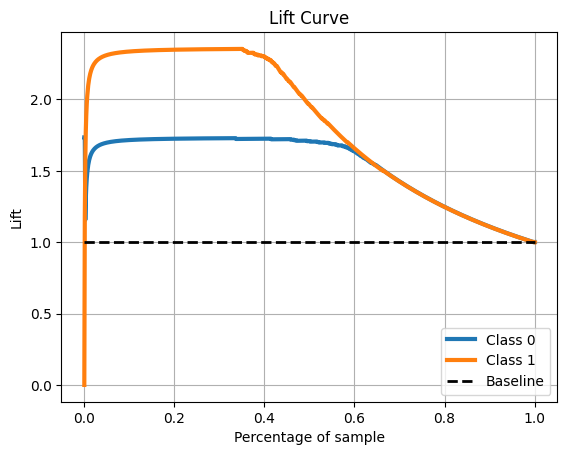

In [52]:
prob = lgb_clf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, prob)
skplt.metrics.plot_lift_curve(y_test, prob)

The ROC curve performs well (closed to top left).

The lift curve shows that when capturing 20% of sample, the predictive model will get 1.75 times more 'not spam' data than random model (class=0), and 2.25 times more 'spam' than random one (class=1).

In [57]:
cm = confusion_matrix(y_test, y_pred_lgb)
cost = cm[0][1]*10 + cm[1][0]*1
avg_cost = cost/(cm.sum())
print('The cost is', cost)
print('The average misclassification cost is', avg_cost)

The cost is 139
The average misclassification cost is 0.15092290988056462


## Conclusion

In model(i) evaluating accuracy and model(ii) evaluating cost‑sensitive, the best model are both light GBM, but the best learning rates are different.